# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

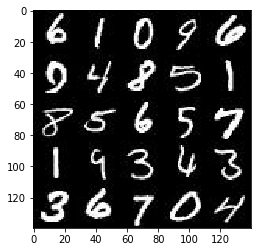

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

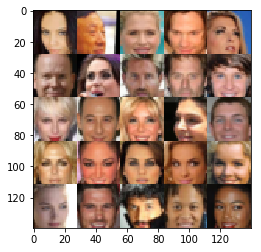

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
     # TODO: Implement Function
    #n_units = 128
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        # strides = 2 #if layer_depth % 3 == 0 else 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', activation=None)
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(images, 256, 5, strides=2, padding='same', activation=None)
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flatten = tf.contrib.layers.flatten(h3)
        logits = tf.layers.dense(flatten, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    #n_units = 128
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        #print(x1.shape.as_list())

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape.as_list())
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape.as_list())
        # 28x28x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x5 now
        
        out = tf.tanh(logits)
        #print(out.shape.as_list())
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, show_every = 100, print_every = 100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inputs, fake_inputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, fake_inputs, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    samples, losses = [], []
    steps = 0
    
    #print_every = 50
    #show_every = 200
    n_img_show = 16
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, 
                             feed_dict={real_inputs: batch_images, fake_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, 
                             feed_dict={real_inputs: batch_images, fake_inputs: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_inputs: batch_images, fake_inputs: batch_z})
                    train_loss_g = g_loss.eval({fake_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
            show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5794... Generator Loss: 2.6900


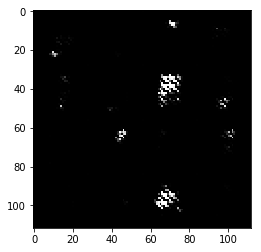

Epoch 1/2... Discriminator Loss: 0.0226... Generator Loss: 8.5083


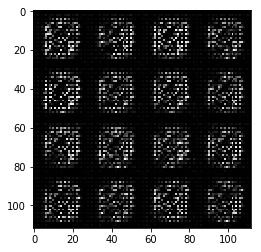

Epoch 1/2... Discriminator Loss: 3.0400... Generator Loss: 10.5053


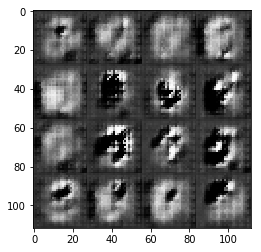

Epoch 1/2... Discriminator Loss: 2.3835... Generator Loss: 0.4825


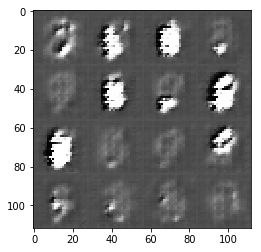

Epoch 1/2... Discriminator Loss: 2.1315... Generator Loss: 3.7764


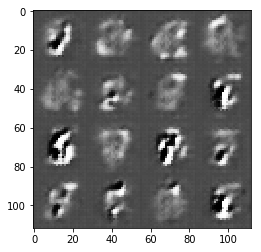

Epoch 1/2... Discriminator Loss: 1.8727... Generator Loss: 0.3248


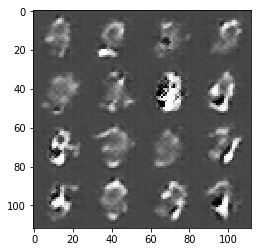

Epoch 1/2... Discriminator Loss: 0.3512... Generator Loss: 5.0816


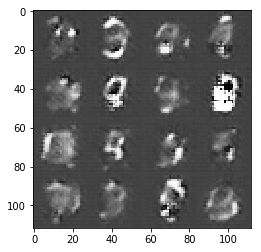

Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 2.2602


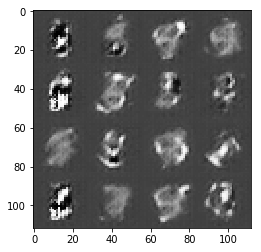

Epoch 1/2... Discriminator Loss: 1.4774... Generator Loss: 3.1478


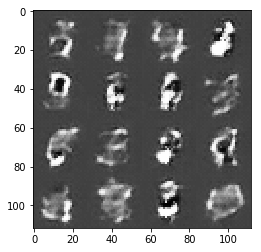

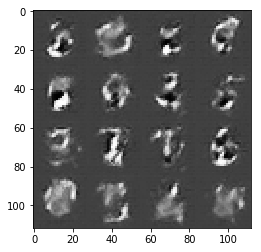

Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 3.7518


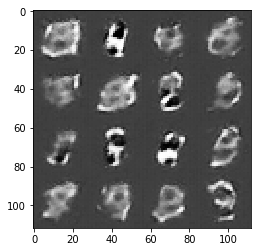

Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.7401


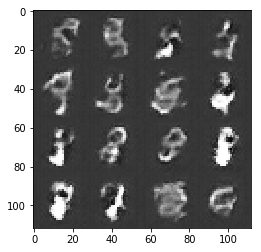

Epoch 2/2... Discriminator Loss: 0.4705... Generator Loss: 1.9305


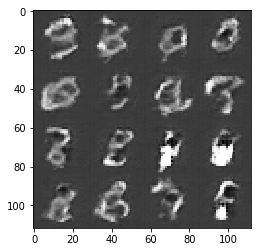

Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.5766


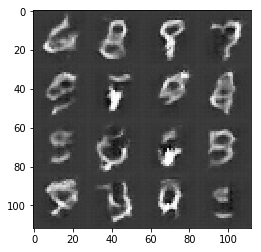

Epoch 2/2... Discriminator Loss: 1.5746... Generator Loss: 0.3978


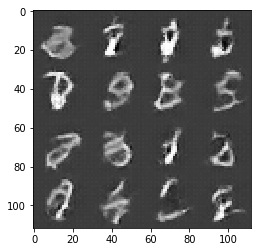

Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 3.2697


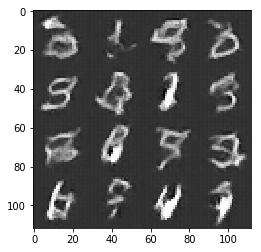

Epoch 2/2... Discriminator Loss: 1.5754... Generator Loss: 0.4780


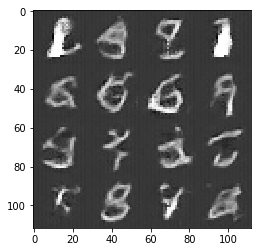

Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 1.5284


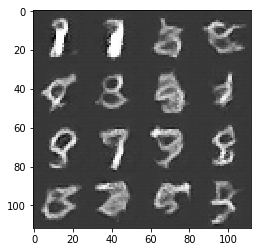

Epoch 2/2... Discriminator Loss: 1.4705... Generator Loss: 3.4970


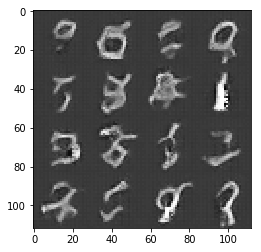

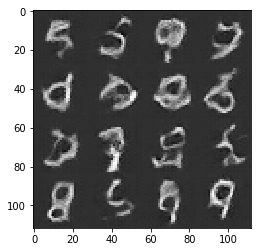

In [12]:
batch_size = 64
z_dim = 200
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, show_every=100, print_every=100)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 0.1215... Generator Loss: 12.8626
Epoch 1/10... Discriminator Loss: 1.4510... Generator Loss: 1.6185
Epoch 1/10... Discriminator Loss: 1.2007... Generator Loss: 1.6964
Epoch 1/10... Discriminator Loss: 1.8955... Generator Loss: 0.7938
Epoch 1/10... Discriminator Loss: 0.6693... Generator Loss: 2.4384
Epoch 1/10... Discriminator Loss: 1.4624... Generator Loss: 2.5757
Epoch 1/10... Discriminator Loss: 3.1435... Generator Loss: 4.1036
Epoch 1/10... Discriminator Loss: 1.1901... Generator Loss: 2.3126
Epoch 1/10... Discriminator Loss: 2.0964... Generator Loss: 0.3391
Epoch 1/10... Discriminator Loss: 1.4802... Generator Loss: 2.6910


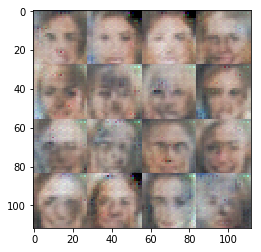

Epoch 1/10... Discriminator Loss: 2.0391... Generator Loss: 0.8530
Epoch 1/10... Discriminator Loss: 1.4921... Generator Loss: 1.0207
Epoch 1/10... Discriminator Loss: 2.1629... Generator Loss: 3.0028
Epoch 1/10... Discriminator Loss: 1.6611... Generator Loss: 0.6428
Epoch 1/10... Discriminator Loss: 1.4875... Generator Loss: 0.7393
Epoch 1/10... Discriminator Loss: 2.1239... Generator Loss: 0.2585
Epoch 1/10... Discriminator Loss: 1.3749... Generator Loss: 1.8622
Epoch 1/10... Discriminator Loss: 1.1471... Generator Loss: 1.0527
Epoch 1/10... Discriminator Loss: 1.0766... Generator Loss: 2.0162
Epoch 1/10... Discriminator Loss: 0.7325... Generator Loss: 2.5620


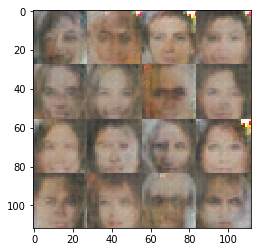

Epoch 1/10... Discriminator Loss: 2.5147... Generator Loss: 2.7610
Epoch 1/10... Discriminator Loss: 1.6179... Generator Loss: 0.4600
Epoch 1/10... Discriminator Loss: 1.7438... Generator Loss: 0.3428
Epoch 1/10... Discriminator Loss: 1.4852... Generator Loss: 1.3014
Epoch 1/10... Discriminator Loss: 1.2854... Generator Loss: 1.1204
Epoch 1/10... Discriminator Loss: 1.7586... Generator Loss: 1.2321
Epoch 1/10... Discriminator Loss: 2.0660... Generator Loss: 0.2772
Epoch 1/10... Discriminator Loss: 1.5565... Generator Loss: 1.9583
Epoch 1/10... Discriminator Loss: 1.2345... Generator Loss: 1.2577
Epoch 1/10... Discriminator Loss: 1.5299... Generator Loss: 0.6451


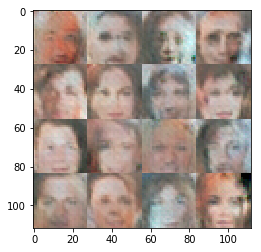

Epoch 1/10... Discriminator Loss: 2.0997... Generator Loss: 0.4480


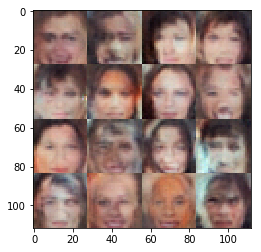

Epoch 2/10... Discriminator Loss: 1.3707... Generator Loss: 1.5313
Epoch 2/10... Discriminator Loss: 2.1938... Generator Loss: 1.7454
Epoch 2/10... Discriminator Loss: 1.2855... Generator Loss: 0.7885
Epoch 2/10... Discriminator Loss: 2.0841... Generator Loss: 2.5818
Epoch 2/10... Discriminator Loss: 1.2752... Generator Loss: 0.8562
Epoch 2/10... Discriminator Loss: 1.1248... Generator Loss: 1.9129
Epoch 2/10... Discriminator Loss: 1.5439... Generator Loss: 0.9806
Epoch 2/10... Discriminator Loss: 1.4869... Generator Loss: 1.1601
Epoch 2/10... Discriminator Loss: 2.1935... Generator Loss: 1.9400


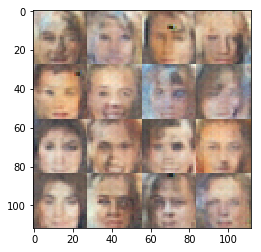

Epoch 2/10... Discriminator Loss: 1.3984... Generator Loss: 0.8809
Epoch 2/10... Discriminator Loss: 1.0035... Generator Loss: 0.8792
Epoch 2/10... Discriminator Loss: 1.5365... Generator Loss: 1.4136
Epoch 2/10... Discriminator Loss: 1.6023... Generator Loss: 0.6624
Epoch 2/10... Discriminator Loss: 2.1191... Generator Loss: 0.2437
Epoch 2/10... Discriminator Loss: 1.5366... Generator Loss: 0.7615
Epoch 2/10... Discriminator Loss: 1.8277... Generator Loss: 0.7179
Epoch 2/10... Discriminator Loss: 1.7687... Generator Loss: 0.3513
Epoch 2/10... Discriminator Loss: 1.9719... Generator Loss: 0.8444
Epoch 2/10... Discriminator Loss: 1.8518... Generator Loss: 0.3870


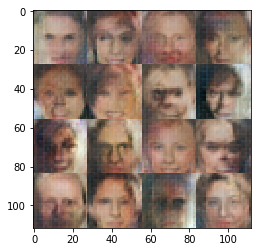

Epoch 2/10... Discriminator Loss: 2.2929... Generator Loss: 0.2277
Epoch 2/10... Discriminator Loss: 1.7458... Generator Loss: 0.4734
Epoch 2/10... Discriminator Loss: 1.5374... Generator Loss: 0.9748
Epoch 2/10... Discriminator Loss: 1.9877... Generator Loss: 0.3430
Epoch 2/10... Discriminator Loss: 1.5164... Generator Loss: 0.6428
Epoch 2/10... Discriminator Loss: 1.7842... Generator Loss: 0.3775
Epoch 2/10... Discriminator Loss: 1.9746... Generator Loss: 0.2238
Epoch 2/10... Discriminator Loss: 1.3984... Generator Loss: 0.6948
Epoch 2/10... Discriminator Loss: 1.6961... Generator Loss: 0.4860
Epoch 2/10... Discriminator Loss: 1.5425... Generator Loss: 1.2032


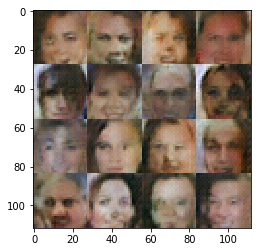

Epoch 2/10... Discriminator Loss: 1.8139... Generator Loss: 0.9541
Epoch 2/10... Discriminator Loss: 1.5126... Generator Loss: 0.4457
Epoch 2/10... Discriminator Loss: 1.5357... Generator Loss: 1.0523


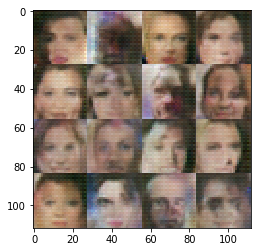

Epoch 3/10... Discriminator Loss: 1.5901... Generator Loss: 0.4570
Epoch 3/10... Discriminator Loss: 1.7022... Generator Loss: 0.4437
Epoch 3/10... Discriminator Loss: 1.7119... Generator Loss: 1.0685
Epoch 3/10... Discriminator Loss: 1.6921... Generator Loss: 0.6397
Epoch 3/10... Discriminator Loss: 1.6395... Generator Loss: 0.5556
Epoch 3/10... Discriminator Loss: 1.6636... Generator Loss: 0.5559
Epoch 3/10... Discriminator Loss: 1.6756... Generator Loss: 0.3535


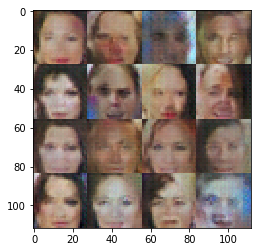

Epoch 3/10... Discriminator Loss: 1.5124... Generator Loss: 0.5299
Epoch 3/10... Discriminator Loss: 1.6718... Generator Loss: 0.8046
Epoch 3/10... Discriminator Loss: 1.5799... Generator Loss: 0.5832
Epoch 3/10... Discriminator Loss: 1.5605... Generator Loss: 0.4264
Epoch 3/10... Discriminator Loss: 1.5286... Generator Loss: 0.5583
Epoch 3/10... Discriminator Loss: 1.5056... Generator Loss: 0.6616
Epoch 3/10... Discriminator Loss: 1.4084... Generator Loss: 0.5484
Epoch 3/10... Discriminator Loss: 1.6529... Generator Loss: 0.7121
Epoch 3/10... Discriminator Loss: 1.6278... Generator Loss: 0.3909
Epoch 3/10... Discriminator Loss: 1.5853... Generator Loss: 0.4506


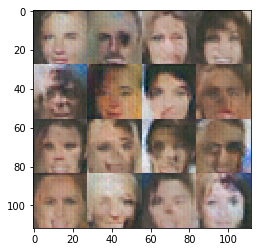

Epoch 3/10... Discriminator Loss: 1.5278... Generator Loss: 0.5639
Epoch 3/10... Discriminator Loss: 1.4490... Generator Loss: 0.6181
Epoch 3/10... Discriminator Loss: 1.5476... Generator Loss: 0.9270
Epoch 3/10... Discriminator Loss: 1.5105... Generator Loss: 0.6657
Epoch 3/10... Discriminator Loss: 1.5656... Generator Loss: 0.4931
Epoch 3/10... Discriminator Loss: 1.5308... Generator Loss: 0.6794
Epoch 3/10... Discriminator Loss: 1.7783... Generator Loss: 0.3420
Epoch 3/10... Discriminator Loss: 1.7467... Generator Loss: 0.3006
Epoch 3/10... Discriminator Loss: 1.6193... Generator Loss: 0.6906
Epoch 3/10... Discriminator Loss: 1.4986... Generator Loss: 0.5199


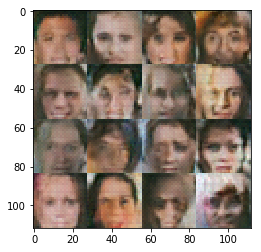

Epoch 3/10... Discriminator Loss: 1.4368... Generator Loss: 0.9434
Epoch 3/10... Discriminator Loss: 1.3957... Generator Loss: 0.6527
Epoch 3/10... Discriminator Loss: 1.4911... Generator Loss: 0.6452
Epoch 3/10... Discriminator Loss: 1.4189... Generator Loss: 0.6128


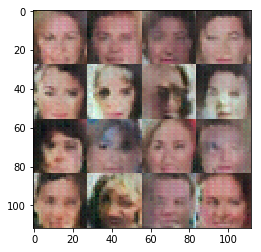

Epoch 4/10... Discriminator Loss: 1.2828... Generator Loss: 0.9261
Epoch 4/10... Discriminator Loss: 1.6221... Generator Loss: 0.4614
Epoch 4/10... Discriminator Loss: 1.5651... Generator Loss: 0.6509
Epoch 4/10... Discriminator Loss: 1.4756... Generator Loss: 0.5545
Epoch 4/10... Discriminator Loss: 1.4536... Generator Loss: 0.6807
Epoch 4/10... Discriminator Loss: 1.4993... Generator Loss: 0.6954


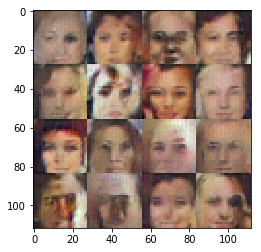

Epoch 4/10... Discriminator Loss: 1.5053... Generator Loss: 0.6307
Epoch 4/10... Discriminator Loss: 1.5546... Generator Loss: 0.8410
Epoch 4/10... Discriminator Loss: 1.5243... Generator Loss: 0.5375
Epoch 4/10... Discriminator Loss: 1.4678... Generator Loss: 0.7613
Epoch 4/10... Discriminator Loss: 1.6197... Generator Loss: 0.9459
Epoch 4/10... Discriminator Loss: 1.5764... Generator Loss: 0.4348
Epoch 4/10... Discriminator Loss: 1.4482... Generator Loss: 0.6651
Epoch 4/10... Discriminator Loss: 1.5419... Generator Loss: 0.5405
Epoch 4/10... Discriminator Loss: 1.6833... Generator Loss: 0.5710
Epoch 4/10... Discriminator Loss: 1.5298... Generator Loss: 0.6809


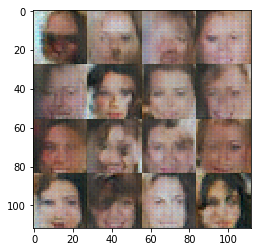

Epoch 4/10... Discriminator Loss: 1.4950... Generator Loss: 0.6225
Epoch 4/10... Discriminator Loss: 1.5938... Generator Loss: 0.4211
Epoch 4/10... Discriminator Loss: 1.4979... Generator Loss: 0.5652
Epoch 4/10... Discriminator Loss: 1.4866... Generator Loss: 0.5345
Epoch 4/10... Discriminator Loss: 1.5604... Generator Loss: 0.5654
Epoch 4/10... Discriminator Loss: 1.4613... Generator Loss: 0.5449
Epoch 4/10... Discriminator Loss: 1.5422... Generator Loss: 0.6601
Epoch 4/10... Discriminator Loss: 1.4844... Generator Loss: 0.9750
Epoch 4/10... Discriminator Loss: 1.4363... Generator Loss: 0.6654
Epoch 4/10... Discriminator Loss: 1.5004... Generator Loss: 0.5774


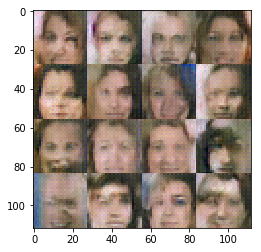

Epoch 4/10... Discriminator Loss: 1.4818... Generator Loss: 0.5523
Epoch 4/10... Discriminator Loss: 1.5174... Generator Loss: 0.4587
Epoch 4/10... Discriminator Loss: 1.4374... Generator Loss: 0.6287
Epoch 4/10... Discriminator Loss: 1.6062... Generator Loss: 0.8415
Epoch 4/10... Discriminator Loss: 1.5445... Generator Loss: 0.4732
Epoch 4/10... Discriminator Loss: 1.3888... Generator Loss: 0.7036


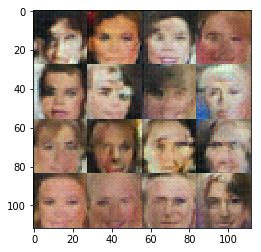

Epoch 5/10... Discriminator Loss: 1.4601... Generator Loss: 0.6534
Epoch 5/10... Discriminator Loss: 1.4157... Generator Loss: 0.7535
Epoch 5/10... Discriminator Loss: 1.4506... Generator Loss: 0.6493
Epoch 5/10... Discriminator Loss: 1.4516... Generator Loss: 0.7312


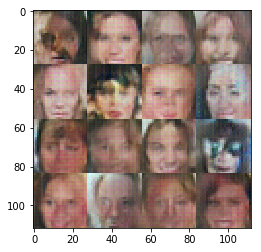

Epoch 5/10... Discriminator Loss: 1.4914... Generator Loss: 0.7035
Epoch 5/10... Discriminator Loss: 1.4440... Generator Loss: 0.6305
Epoch 5/10... Discriminator Loss: 1.4793... Generator Loss: 0.7560
Epoch 5/10... Discriminator Loss: 1.3741... Generator Loss: 0.8293
Epoch 5/10... Discriminator Loss: 1.4568... Generator Loss: 0.7133
Epoch 5/10... Discriminator Loss: 1.4800... Generator Loss: 0.6075
Epoch 5/10... Discriminator Loss: 1.5035... Generator Loss: 0.8892
Epoch 5/10... Discriminator Loss: 1.4641... Generator Loss: 0.8498
Epoch 5/10... Discriminator Loss: 1.4525... Generator Loss: 0.5920
Epoch 5/10... Discriminator Loss: 1.4221... Generator Loss: 0.6319


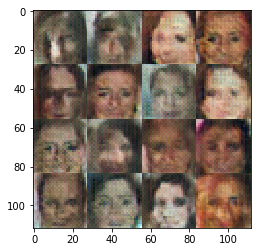

Epoch 5/10... Discriminator Loss: 1.4628... Generator Loss: 0.6840
Epoch 5/10... Discriminator Loss: 1.5498... Generator Loss: 0.9206
Epoch 5/10... Discriminator Loss: 1.5404... Generator Loss: 0.6939
Epoch 5/10... Discriminator Loss: 1.4073... Generator Loss: 0.6392
Epoch 5/10... Discriminator Loss: 1.4592... Generator Loss: 0.4916
Epoch 5/10... Discriminator Loss: 1.4201... Generator Loss: 0.8447
Epoch 5/10... Discriminator Loss: 1.4167... Generator Loss: 0.6676
Epoch 5/10... Discriminator Loss: 1.4467... Generator Loss: 0.6536
Epoch 5/10... Discriminator Loss: 1.4198... Generator Loss: 0.7498
Epoch 5/10... Discriminator Loss: 1.4627... Generator Loss: 0.6314


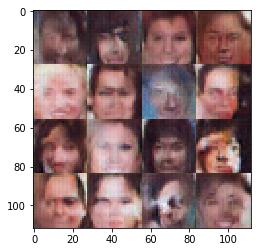

Epoch 5/10... Discriminator Loss: 1.4434... Generator Loss: 0.6283
Epoch 5/10... Discriminator Loss: 1.5393... Generator Loss: 0.9704
Epoch 5/10... Discriminator Loss: 1.4269... Generator Loss: 0.6502
Epoch 5/10... Discriminator Loss: 1.4509... Generator Loss: 0.7425
Epoch 5/10... Discriminator Loss: 1.4819... Generator Loss: 0.8464
Epoch 5/10... Discriminator Loss: 1.4584... Generator Loss: 0.6855
Epoch 5/10... Discriminator Loss: 1.3835... Generator Loss: 0.7166
Epoch 5/10... Discriminator Loss: 1.4597... Generator Loss: 0.7080


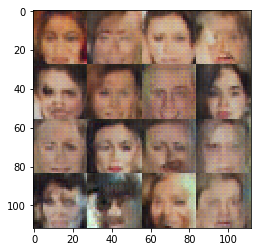

Epoch 6/10... Discriminator Loss: 1.4520... Generator Loss: 0.5973
Epoch 6/10... Discriminator Loss: 1.4224... Generator Loss: 0.6751


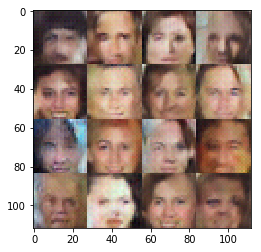

Epoch 6/10... Discriminator Loss: 1.3982... Generator Loss: 0.6933
Epoch 6/10... Discriminator Loss: 1.4527... Generator Loss: 0.6872
Epoch 6/10... Discriminator Loss: 1.4234... Generator Loss: 0.5634
Epoch 6/10... Discriminator Loss: 1.4568... Generator Loss: 0.6027
Epoch 6/10... Discriminator Loss: 1.4152... Generator Loss: 0.7242
Epoch 6/10... Discriminator Loss: 1.4254... Generator Loss: 0.5713
Epoch 6/10... Discriminator Loss: 1.4244... Generator Loss: 0.6060
Epoch 6/10... Discriminator Loss: 1.3775... Generator Loss: 0.6100
Epoch 6/10... Discriminator Loss: 1.3797... Generator Loss: 0.7888
Epoch 6/10... Discriminator Loss: 1.4252... Generator Loss: 0.8462


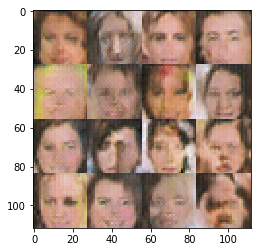

Epoch 6/10... Discriminator Loss: 1.4333... Generator Loss: 0.5118
Epoch 6/10... Discriminator Loss: 1.4474... Generator Loss: 0.6850
Epoch 6/10... Discriminator Loss: 1.4409... Generator Loss: 0.5277
Epoch 6/10... Discriminator Loss: 1.4212... Generator Loss: 0.5268
Epoch 6/10... Discriminator Loss: 1.4657... Generator Loss: 0.9289
Epoch 6/10... Discriminator Loss: 1.4341... Generator Loss: 0.6271
Epoch 6/10... Discriminator Loss: 1.4360... Generator Loss: 0.6261
Epoch 6/10... Discriminator Loss: 1.3792... Generator Loss: 0.5985
Epoch 6/10... Discriminator Loss: 1.4239... Generator Loss: 0.6319
Epoch 6/10... Discriminator Loss: 1.4380... Generator Loss: 0.8109


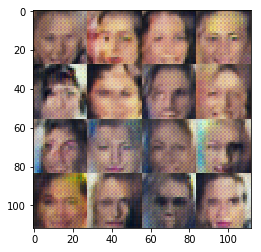

Epoch 6/10... Discriminator Loss: 1.4137... Generator Loss: 0.6847
Epoch 6/10... Discriminator Loss: 1.4430... Generator Loss: 0.6907
Epoch 6/10... Discriminator Loss: 1.4042... Generator Loss: 0.6685
Epoch 6/10... Discriminator Loss: 1.4149... Generator Loss: 0.5940
Epoch 6/10... Discriminator Loss: 1.4067... Generator Loss: 0.7322
Epoch 6/10... Discriminator Loss: 1.3684... Generator Loss: 0.6892
Epoch 6/10... Discriminator Loss: 1.4119... Generator Loss: 0.8819
Epoch 6/10... Discriminator Loss: 1.4623... Generator Loss: 0.8391
Epoch 6/10... Discriminator Loss: 1.3998... Generator Loss: 0.6972


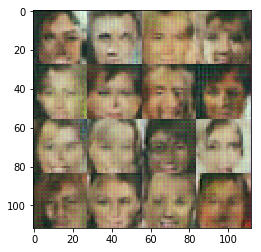

Epoch 7/10... Discriminator Loss: 1.3986... Generator Loss: 0.6286


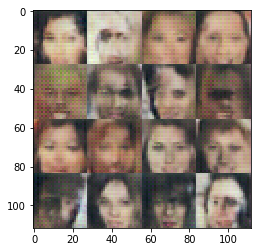

Epoch 7/10... Discriminator Loss: 1.4346... Generator Loss: 0.6855
Epoch 7/10... Discriminator Loss: 1.3825... Generator Loss: 0.7166
Epoch 7/10... Discriminator Loss: 1.4015... Generator Loss: 0.6569
Epoch 7/10... Discriminator Loss: 1.3947... Generator Loss: 0.6859
Epoch 7/10... Discriminator Loss: 1.4460... Generator Loss: 0.8457
Epoch 7/10... Discriminator Loss: 1.4426... Generator Loss: 0.8058
Epoch 7/10... Discriminator Loss: 1.3961... Generator Loss: 0.6522
Epoch 7/10... Discriminator Loss: 1.3951... Generator Loss: 0.7670
Epoch 7/10... Discriminator Loss: 1.3955... Generator Loss: 0.6586
Epoch 7/10... Discriminator Loss: 1.3649... Generator Loss: 0.7253


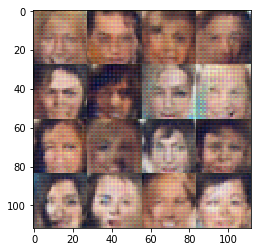

Epoch 7/10... Discriminator Loss: 1.4277... Generator Loss: 0.7214
Epoch 7/10... Discriminator Loss: 1.3940... Generator Loss: 0.7701
Epoch 7/10... Discriminator Loss: 1.4285... Generator Loss: 0.5834
Epoch 7/10... Discriminator Loss: 1.4044... Generator Loss: 0.7582
Epoch 7/10... Discriminator Loss: 1.3999... Generator Loss: 0.6119
Epoch 7/10... Discriminator Loss: 1.4095... Generator Loss: 0.6364
Epoch 7/10... Discriminator Loss: 1.3823... Generator Loss: 0.6786
Epoch 7/10... Discriminator Loss: 1.3761... Generator Loss: 0.7446
Epoch 7/10... Discriminator Loss: 1.3902... Generator Loss: 0.6745
Epoch 7/10... Discriminator Loss: 1.4217... Generator Loss: 0.6671


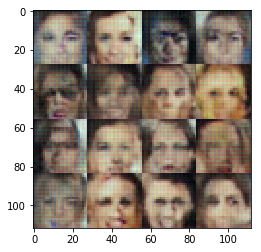

Epoch 7/10... Discriminator Loss: 1.4074... Generator Loss: 0.6939
Epoch 7/10... Discriminator Loss: 1.4235... Generator Loss: 0.5832
Epoch 7/10... Discriminator Loss: 1.3967... Generator Loss: 0.6950
Epoch 7/10... Discriminator Loss: 1.4029... Generator Loss: 0.6594
Epoch 7/10... Discriminator Loss: 1.4204... Generator Loss: 0.5580
Epoch 7/10... Discriminator Loss: 1.3628... Generator Loss: 0.6883
Epoch 7/10... Discriminator Loss: 1.4074... Generator Loss: 0.6892
Epoch 7/10... Discriminator Loss: 1.4189... Generator Loss: 0.7334
Epoch 7/10... Discriminator Loss: 1.4209... Generator Loss: 0.6881
Epoch 7/10... Discriminator Loss: 1.4089... Generator Loss: 0.8055


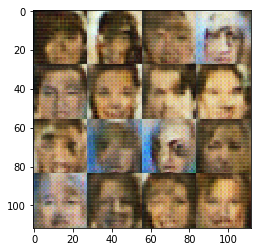

Epoch 7/10... Discriminator Loss: 1.3980... Generator Loss: 0.6992


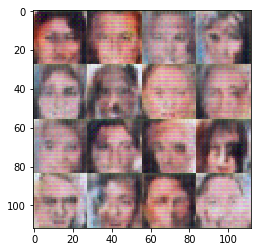

Epoch 8/10... Discriminator Loss: 1.4033... Generator Loss: 0.6850
Epoch 8/10... Discriminator Loss: 1.3805... Generator Loss: 0.6449
Epoch 8/10... Discriminator Loss: 1.4070... Generator Loss: 0.6822
Epoch 8/10... Discriminator Loss: 1.4098... Generator Loss: 0.7114
Epoch 8/10... Discriminator Loss: 1.4140... Generator Loss: 0.6773
Epoch 8/10... Discriminator Loss: 1.3924... Generator Loss: 0.6750
Epoch 8/10... Discriminator Loss: 1.4650... Generator Loss: 0.5782
Epoch 8/10... Discriminator Loss: 1.3999... Generator Loss: 0.6536
Epoch 8/10... Discriminator Loss: 1.4222... Generator Loss: 0.6415


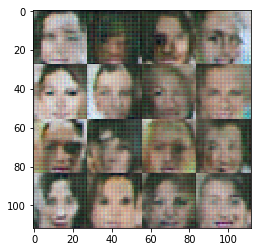

Epoch 8/10... Discriminator Loss: 1.3881... Generator Loss: 0.6982
Epoch 8/10... Discriminator Loss: 1.3839... Generator Loss: 0.6956
Epoch 8/10... Discriminator Loss: 1.4017... Generator Loss: 0.6395
Epoch 8/10... Discriminator Loss: 1.3676... Generator Loss: 0.6957
Epoch 8/10... Discriminator Loss: 1.3973... Generator Loss: 0.5857
Epoch 8/10... Discriminator Loss: 1.4172... Generator Loss: 0.7489
Epoch 8/10... Discriminator Loss: 1.3861... Generator Loss: 0.6776
Epoch 8/10... Discriminator Loss: 1.3778... Generator Loss: 0.7225
Epoch 8/10... Discriminator Loss: 1.3862... Generator Loss: 0.6972
Epoch 8/10... Discriminator Loss: 1.3989... Generator Loss: 0.6690


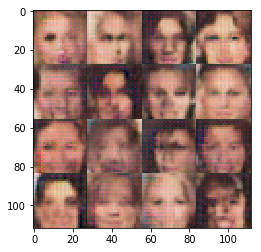

Epoch 8/10... Discriminator Loss: 1.3922... Generator Loss: 0.7148
Epoch 8/10... Discriminator Loss: 1.4085... Generator Loss: 0.6156
Epoch 8/10... Discriminator Loss: 1.3863... Generator Loss: 0.6901
Epoch 8/10... Discriminator Loss: 1.3533... Generator Loss: 0.7247
Epoch 8/10... Discriminator Loss: 1.4008... Generator Loss: 0.6231
Epoch 8/10... Discriminator Loss: 1.3746... Generator Loss: 0.6716
Epoch 8/10... Discriminator Loss: 1.3873... Generator Loss: 0.6485
Epoch 8/10... Discriminator Loss: 1.3727... Generator Loss: 0.6905
Epoch 8/10... Discriminator Loss: 1.3885... Generator Loss: 0.6293
Epoch 8/10... Discriminator Loss: 1.3938... Generator Loss: 0.6936


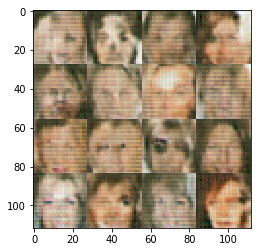

Epoch 8/10... Discriminator Loss: 1.3764... Generator Loss: 0.6998
Epoch 8/10... Discriminator Loss: 1.4256... Generator Loss: 0.6253
Epoch 8/10... Discriminator Loss: 1.4375... Generator Loss: 0.8776


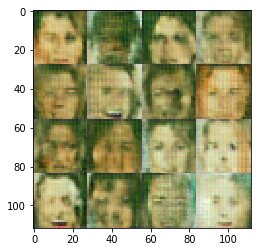

Epoch 9/10... Discriminator Loss: 1.3959... Generator Loss: 0.7008
Epoch 9/10... Discriminator Loss: 1.3931... Generator Loss: 0.6175
Epoch 9/10... Discriminator Loss: 1.3955... Generator Loss: 0.6881
Epoch 9/10... Discriminator Loss: 1.3705... Generator Loss: 0.7069
Epoch 9/10... Discriminator Loss: 1.3582... Generator Loss: 0.6902
Epoch 9/10... Discriminator Loss: 1.3961... Generator Loss: 0.7172
Epoch 9/10... Discriminator Loss: 1.3487... Generator Loss: 0.6260


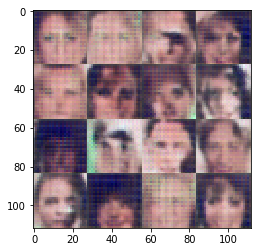

Epoch 9/10... Discriminator Loss: 1.4194... Generator Loss: 0.6381
Epoch 9/10... Discriminator Loss: 1.3698... Generator Loss: 0.7155
Epoch 9/10... Discriminator Loss: 1.3920... Generator Loss: 0.6665
Epoch 9/10... Discriminator Loss: 1.3789... Generator Loss: 0.6602
Epoch 9/10... Discriminator Loss: 1.4019... Generator Loss: 0.7159
Epoch 9/10... Discriminator Loss: 1.4066... Generator Loss: 0.7411
Epoch 9/10... Discriminator Loss: 1.3816... Generator Loss: 0.6361
Epoch 9/10... Discriminator Loss: 1.3765... Generator Loss: 0.6880
Epoch 9/10... Discriminator Loss: 1.3887... Generator Loss: 0.6969
Epoch 9/10... Discriminator Loss: 1.3817... Generator Loss: 0.6694


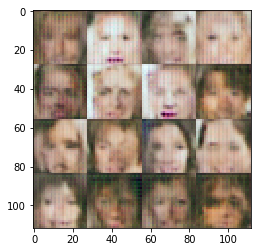

Epoch 9/10... Discriminator Loss: 1.5044... Generator Loss: 0.6097
Epoch 9/10... Discriminator Loss: 1.3966... Generator Loss: 0.6988
Epoch 9/10... Discriminator Loss: 1.3918... Generator Loss: 0.6706
Epoch 9/10... Discriminator Loss: 1.3922... Generator Loss: 0.6992
Epoch 9/10... Discriminator Loss: 1.4327... Generator Loss: 0.8064
Epoch 9/10... Discriminator Loss: 1.3842... Generator Loss: 0.6942
Epoch 9/10... Discriminator Loss: 1.3843... Generator Loss: 0.6789
Epoch 9/10... Discriminator Loss: 1.4026... Generator Loss: 0.6061
Epoch 9/10... Discriminator Loss: 1.3949... Generator Loss: 0.7412
Epoch 9/10... Discriminator Loss: 1.3834... Generator Loss: 0.7036


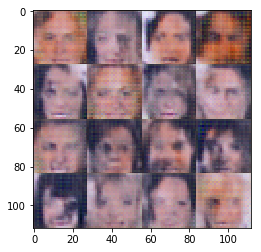

Epoch 9/10... Discriminator Loss: 1.4298... Generator Loss: 0.9021
Epoch 9/10... Discriminator Loss: 1.4088... Generator Loss: 0.6915
Epoch 9/10... Discriminator Loss: 1.3994... Generator Loss: 0.7044
Epoch 9/10... Discriminator Loss: 1.4213... Generator Loss: 0.7200


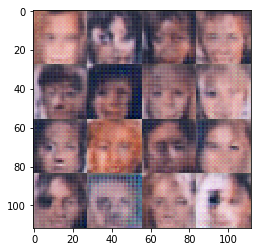

Epoch 10/10... Discriminator Loss: 1.3970... Generator Loss: 0.7251
Epoch 10/10... Discriminator Loss: 1.3912... Generator Loss: 0.7087
Epoch 10/10... Discriminator Loss: 1.3975... Generator Loss: 0.6495
Epoch 10/10... Discriminator Loss: 1.4133... Generator Loss: 0.8592
Epoch 10/10... Discriminator Loss: 1.4116... Generator Loss: 0.6003
Epoch 10/10... Discriminator Loss: 1.3522... Generator Loss: 0.6921


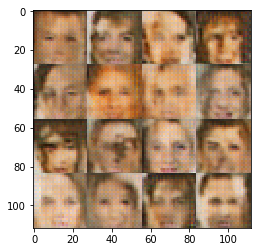

Epoch 10/10... Discriminator Loss: 1.3906... Generator Loss: 0.6590
Epoch 10/10... Discriminator Loss: 1.4052... Generator Loss: 0.6662
Epoch 10/10... Discriminator Loss: 1.4058... Generator Loss: 0.6665
Epoch 10/10... Discriminator Loss: 1.3898... Generator Loss: 0.7034
Epoch 10/10... Discriminator Loss: 1.3620... Generator Loss: 0.6893
Epoch 10/10... Discriminator Loss: 1.3853... Generator Loss: 0.6821
Epoch 10/10... Discriminator Loss: 1.3881... Generator Loss: 0.6889
Epoch 10/10... Discriminator Loss: 1.3864... Generator Loss: 0.7739
Epoch 10/10... Discriminator Loss: 1.3993... Generator Loss: 0.6537
Epoch 10/10... Discriminator Loss: 1.3950... Generator Loss: 0.6429


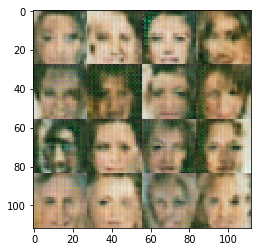

Epoch 10/10... Discriminator Loss: 1.3869... Generator Loss: 0.6956
Epoch 10/10... Discriminator Loss: 1.3877... Generator Loss: 0.7038
Epoch 10/10... Discriminator Loss: 1.3764... Generator Loss: 0.6992
Epoch 10/10... Discriminator Loss: 1.3863... Generator Loss: 0.7717
Epoch 10/10... Discriminator Loss: 1.3757... Generator Loss: 0.7417
Epoch 10/10... Discriminator Loss: 1.3917... Generator Loss: 0.7468
Epoch 10/10... Discriminator Loss: 1.4064... Generator Loss: 0.6577
Epoch 10/10... Discriminator Loss: 1.3812... Generator Loss: 0.7076
Epoch 10/10... Discriminator Loss: 1.3784... Generator Loss: 0.6915
Epoch 10/10... Discriminator Loss: 1.3780... Generator Loss: 0.7419


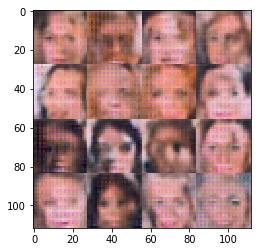

Epoch 10/10... Discriminator Loss: 1.3808... Generator Loss: 0.6947
Epoch 10/10... Discriminator Loss: 1.4025... Generator Loss: 0.6255
Epoch 10/10... Discriminator Loss: 1.3796... Generator Loss: 0.8453
Epoch 10/10... Discriminator Loss: 1.3815... Generator Loss: 0.7115
Epoch 10/10... Discriminator Loss: 1.3959... Generator Loss: 0.6732
Epoch 10/10... Discriminator Loss: 1.3579... Generator Loss: 0.7145


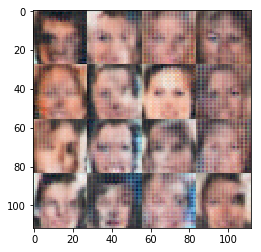

In [13]:
batch_size = 64
z_dim = 200
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, show_every=1000, print_every=100)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.